In [3]:
"""
=============================================================================
BODY ABLATION RESEARCH SCRIPT
=============================================================================

This script performs comprehensive grid search to find optimal parameters
for the BTC price prediction model.

WHAT IS ABLATION?
-----------------
"Ablation" means removing something to see how it affects the result.
In our case, we remove (exclude) certain astrological bodies from the
feature set to see which ones are most important for prediction.

For example:
    - Exclude Mercury → model gets WORSE (Mercury is important!)
    - Exclude Pluto → model gets BETTER (Pluto adds noise?)

WHAT THIS SCRIPT DOES:
----------------------
1. BASELINE: Evaluate model with default params (no exclusions)
2. GRID SEARCH: Try ALL combinations of:
   - Coord modes: geo, helio, both
   - Gauss params: window × std (9 combinations)
   - Body exclusions: different planets to exclude (11 variations)
3. BEST MODEL: Show detailed evaluation of the best configuration

GRID SEARCH SPACE:
------------------
Total combinations = 3 coord × 3 windows × 3 stds × 11 exclusions = 297

This takes about 30-60 minutes on GPU, 2-4 hours on CPU.

HOW TO RUN:
-----------
    cd /home/rut/ostrofun
    python -m RESEARCH.body_ablation_research

Or use the Jupyter notebook version:
    jupyter notebook RESEARCH/body_ablation_research.ipynb

=============================================================================
"""
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime
from itertools import product

In [4]:
# =============================================================================
# IMPORTS FROM RESEARCH PACKAGE
# =============================================================================
# These are our custom modules for the research pipeline

import sys
import os
# Add project root to sys.path to allow importing RESEARCH package
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from RESEARCH.data_loader import load_market_data
from RESEARCH.labeling import create_balanced_labels
from RESEARCH.astro_engine import (
    init_ephemeris,                   # Initialize Swiss Ephemeris
    calculate_bodies_for_dates_multi, # Calculate planet positions
    calculate_aspects_for_dates,      # Calculate aspects (angular relationships)
    calculate_phases_for_dates,       # Calculate moon phases, elongations
)
from RESEARCH.features import build_full_features, merge_features_with_labels
from RESEARCH.model_training import (
    split_dataset,                    # Split into train/val/test
    prepare_xy,                       # Prepare X, y arrays
    train_xgb_model,                  # Train XGBoost model
    tune_threshold,                   # Find best probability threshold
    predict_with_threshold,           # Predict using custom threshold
    check_cuda_available,             # Check if GPU is available
)
from RESEARCH.evaluation import evaluate_model_full, compare_models

In [5]:
# =============================================================================
# CONFIGURATION - MODEL HYPERPARAMETERS (FIXED)
# =============================================================================
# These XGBoost parameters were found to work well in previous experiments.
# We keep them fixed during grid search to focus on astro parameters.

MODEL_PARAMS = {
    # -------------------------------------------------------------------------
    # n_estimators: Number of boosting rounds (trees in the ensemble)
    # Higher = more capacity but slower and risk of overfitting
    # 500 is a good balance for our dataset size (~3000 samples)
    # -------------------------------------------------------------------------
    'n_estimators': 500,
    
    # -------------------------------------------------------------------------
    # max_depth: Maximum depth of each tree
    # Deeper trees can capture more complex patterns but overfit easier
    # depth=6 is standard, we use it to prevent overfitting on small data
    # -------------------------------------------------------------------------
    'max_depth': 6,
    
    # -------------------------------------------------------------------------
    # learning_rate: Step size shrinkage
    # Smaller = more conservative updates, better generalization
    # 0.03 works well with 500 estimators
    # -------------------------------------------------------------------------
    'learning_rate': 0.03,
    
    # -------------------------------------------------------------------------
    # colsample_bytree: Fraction of features to use per tree
    # 0.6 = only 60% of features used for each tree (reduces correlation)
    # This acts as regularization to prevent overfitting
    # -------------------------------------------------------------------------
    'colsample_bytree': 0.6,
    
    # -------------------------------------------------------------------------
    # subsample: Fraction of samples to use per tree
    # 0.8 = only 80% of training data used for each tree
    # This is "stochastic gradient boosting" - adds randomness
    # -------------------------------------------------------------------------
    'subsample': 0.8,
}

In [6]:
# =============================================================================
# CONFIGURATION - GRID SEARCH PARAMETERS
# =============================================================================
# These are the astrological/labeling parameters we will search over.

GRID_PARAMS = {
    # -------------------------------------------------------------------------
    # gauss_windows: Size of Gaussian smoothing window (in days)
    # 
    # WHY WE SMOOTH: Raw price data is noisy. A big move one day might
    # reverse the next. Smoothing helps identify "real" trends.
    #
    # Smaller window (150) = more sensitive to short-term moves
    # Larger window (250) = only captures major trends
    # -------------------------------------------------------------------------
    'gauss_windows': [150, 200, 250],
    
    # -------------------------------------------------------------------------
    # gauss_stds: Standard deviation of Gaussian kernel
    #
    # This controls the "shape" of the smoothing:
    # Smaller std (50) = narrow bell, sharp cutoff, focuses on center
    # Larger std (90) = wide bell, includes more surrounding days
    # -------------------------------------------------------------------------
    'gauss_stds': [50.0, 70.0, 90.0],
    
    # -------------------------------------------------------------------------
    # coord_modes: Coordinate system for planetary calculations
    #
    # 'geo' = Geocentric (Earth-centered) - traditional astrology
    #         Moon, Sun, planets as seen FROM Earth
    #
    # 'helio' = Heliocentric (Sun-centered) - astronomical
    #           Planets in their actual orbits around Sun
    #           Note: Moon and Sun are excluded in helio mode!
    #
    # 'both' = BOTH systems combined
    #          Doubles the number of features (geo_Mars_lon, helio_Mars_lon)
    #          More info but also more noise and overfitting risk
    # -------------------------------------------------------------------------
    'coord_modes': ['geo', 'helio', 'both'],
    
    # -------------------------------------------------------------------------
    # orb_mults: Orb multiplier for aspect detection
    #
    # "Orb" is the tolerance for aspects. An exact conjunction is 0°,
    # but we allow some deviation (e.g., 8°).
    #
    # orb_mult=0.1 means we multiply standard orbs by 0.1, making them
    # very strict (only near-exact aspects). This reduces false positives.
    # -------------------------------------------------------------------------
    'orb_mults': [0.1],
}

In [7]:
# =============================================================================
# CONFIGURATION - BODY EXCLUSION COMBINATIONS
# =============================================================================
# Based on single-body ablation study results (see previous experiments),
# these are the most promising bodies to exclude.
#
# WHY EXCLUDE BODIES?
# -------------------
# Some astrological bodies might ADD NOISE rather than signal.
# If excluding a body IMPROVES the model, that body was probably
# not contributing useful information for BTC prediction.
#
# TOP 5 BODIES TO EXCLUDE (from single-body study):
# 1. MeanNode - R_MIN improved by 7.5%
# 2. Pluto - R_MIN improved by 4.5%
# 3. Saturn - slight improvement
# 4. Venus - best MCC improvement
# 5. Neptune - slight improvement

ABLATION_BODIES = [
    # -------------------------------------------------------------------------
    # BASELINE: No exclusions (use all bodies)
    # -------------------------------------------------------------------------
    [],
    
    # -------------------------------------------------------------------------
    # SINGLE BODY EXCLUSIONS: Remove one body at a time
    # -------------------------------------------------------------------------
    ['MeanNode'],   # Top performer in single-body study
    ['Pluto'],      # Second best
    ['Saturn'],     # Third
    ['Venus'],      # Best MCC improvement
    ['Neptune'],    # Fifth
    
    # -------------------------------------------------------------------------
    # PAIR EXCLUSIONS: Remove two bodies together
    # Testing if combined exclusion is better than single
    # -------------------------------------------------------------------------
    ['MeanNode', 'Pluto'],   # Top 2 combined
    ['MeanNode', 'Saturn'],  # #1 + #3
    ['MeanNode', 'Venus'],   # #1 + best MCC
    ['Pluto', 'Saturn'],     # #2 + #3
    ['Pluto', 'Venus'],      # #2 + best MCC
]

In [8]:
# =============================================================================
# HELPER FUNCTION: TRAIN AND EVALUATE ONE CONFIGURATION
# =============================================================================

def train_and_evaluate(
    df_market: pd.DataFrame,
    df_bodies: pd.DataFrame,
    geo_by_date: dict,
    settings,
    gauss_window: int,
    gauss_std: float,
    orb_mult: float,
    exclude_bodies: list = None,
    device: str = 'cpu',
    verbose: bool = False,
):
    """
    Train a model with specific parameters and return evaluation metrics.
    
    THIS IS THE CORE FUNCTION that:
    1. Creates labels (UP/DOWN) using Gaussian smoothing
    2. Calculates astrological features (aspects, phases)
    3. Trains XGBoost model
    4. Evaluates on test set
    
    PARAMETERS:
    -----------
    df_market : pd.DataFrame
        Market data with 'date' and 'close' columns.
        
    df_bodies : pd.DataFrame
        Pre-calculated planetary positions (from calculate_bodies_for_dates_multi).
        
    geo_by_date : dict
        Dictionary mapping date -> list of BodyPosition objects.
        Used for aspect calculations.
        
    settings : AstroSettings
        Ephemeris settings (list of bodies, aspects, etc.)
        
    gauss_window : int
        Gaussian smoothing window size (days).
        
    gauss_std : float
        Gaussian standard deviation.
        
    orb_mult : float
        Orb multiplier for aspects.
        
    exclude_bodies : list, optional
        List of body names to exclude from features.
        Example: ['MeanNode', 'Pluto']
        
    device : str
        'cpu' or 'cuda' for GPU acceleration.
        
    verbose : bool
        Whether to print threshold tuning progress.
    
    RETURNS:
    --------
    Dict with model and metrics, or None if not enough data.
    """
    
    # -------------------------------------------------------------------------
    # STEP 1: Create labels (UP=1, DOWN=0) using Gaussian smoothing
    # -------------------------------------------------------------------------
    # This applies Gaussian filter to price, then labels days as
    # UP (smoothed price increasing) or DOWN (smoothed price decreasing)
    df_labels = create_balanced_labels(
        df_market,
        gauss_window=gauss_window,
        gauss_std=gauss_std,
    )
    
    # -------------------------------------------------------------------------
    # STEP 2: Calculate aspects using pre-cached body positions
    # -------------------------------------------------------------------------
    # Aspects = angular relationships between planets (conjunction, square, etc.)
    df_aspects = calculate_aspects_for_dates(
        geo_by_date, settings, orb_mult=orb_mult, progress=False
    )
    
    # -------------------------------------------------------------------------
    # STEP 3: Calculate moon phases and planet elongations
    # -------------------------------------------------------------------------
    # Moon phase = new moon, full moon, quarters
    # Elongation = angular distance of planet from Sun (morning/evening star)
    df_phases = calculate_phases_for_dates(geo_by_date, progress=False)
    
    # -------------------------------------------------------------------------
    # STEP 4: Build full feature matrix (excluding specified bodies)
    # -------------------------------------------------------------------------
    df_features = build_full_features(
        df_bodies, df_aspects,
        df_phases=df_phases,
        exclude_bodies=exclude_bodies  # This is where ablation happens!
    )
    
    # -------------------------------------------------------------------------
    # STEP 5: Merge features with labels
    # -------------------------------------------------------------------------
    df_dataset = merge_features_with_labels(df_features, df_labels)
    
    # Need at least 100 samples to train meaningfully
    if len(df_dataset) < 100:
        return None
    
    # -------------------------------------------------------------------------
    # STEP 6: Split into train/validation/test sets
    # -------------------------------------------------------------------------
    # Time-based split (no shuffling!) to simulate real trading scenario
    # Train: first 70%, Val: next 15%, Test: final 15%
    train_df, val_df, test_df = split_dataset(df_dataset)
    
    # Extract feature columns (everything except 'date' and 'target')
    feature_cols = [c for c in df_dataset.columns if c not in ['date', 'target']]
    
    # Prepare X (features) and y (labels) arrays
    X_train, y_train = prepare_xy(train_df, feature_cols)
    X_val, y_val = prepare_xy(val_df, feature_cols)
    X_test, y_test = prepare_xy(test_df, feature_cols)
    
    # -------------------------------------------------------------------------
    # STEP 7: Train XGBoost model
    # -------------------------------------------------------------------------
    model = train_xgb_model(
        X_train, y_train, X_val, y_val,
        feature_cols, n_classes=2, device=device,
        **MODEL_PARAMS
    )
    
    # -------------------------------------------------------------------------
    # STEP 8: Tune probability threshold for best recall_min
    # -------------------------------------------------------------------------
    # Default threshold is 0.5 (predict UP if P(UP) > 0.5)
    # But we can adjust this to balance recall between classes
    best_t, _ = tune_threshold(model, X_val, y_val, metric='recall_min', verbose=verbose)
    
    # -------------------------------------------------------------------------
    # STEP 9: Predict on test set using tuned threshold
    # -------------------------------------------------------------------------
    y_pred = predict_with_threshold(model, X_test, threshold=best_t)
    
    # -------------------------------------------------------------------------
    # STEP 10: Calculate evaluation metrics
    # -------------------------------------------------------------------------
    from sklearn.metrics import classification_report, balanced_accuracy_score, matthews_corrcoef
    
    report = classification_report(
        y_test, y_pred, labels=[0, 1],
        target_names=['DOWN', 'UP'], output_dict=True, zero_division=0
    )
    
    recall_down = report['DOWN']['recall']
    recall_up = report['UP']['recall']
    
    return {
        'model': model,
        'threshold': best_t,
        'n_features': len(feature_cols),
        'recall_min': min(recall_down, recall_up),
        'recall_gap': abs(recall_down - recall_up),
        'recall_down': recall_down,
        'recall_up': recall_up,
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'mcc': matthews_corrcoef(y_test, y_pred),
        'f1_macro': report['macro avg']['f1-score'],
        'y_test': y_test,
        'y_pred': y_pred,
        'test_dates': test_df['date'].reset_index(drop=True),
    }

In [9]:
# =============================================================================
# MAIN FUNCTION: RUN FULL GRID SEARCH
# =============================================================================

def run_full_grid_search(df_market, settings, device='cpu'):
    """
    Run comprehensive grid search over all parameter combinations.
    
    This function:
    1. Pre-calculates body positions for each coord mode (expensive, do once)
    2. Iterates through all parameter combinations
    3. Trains and evaluates a model for each combination
    4. Returns DataFrame with all results
    
    ESTIMATED TIME:
    ---------------
    - GPU (CUDA): 30-60 minutes for 297 combinations
    - CPU: 2-4 hours
    
    RETURNS:
    --------
    pd.DataFrame with columns:
        - coord_mode, gauss_window, gauss_std, orb_mult, exclude_bodies
        - n_features, recall_min, recall_gap, balanced_accuracy, mcc, f1_macro
    """
    
    # -------------------------------------------------------------------------
    # Generate all combinations using itertools.product
    # -------------------------------------------------------------------------
    combos = list(product(
        GRID_PARAMS['coord_modes'],
        GRID_PARAMS['gauss_windows'],
        GRID_PARAMS['gauss_stds'],
        GRID_PARAMS['orb_mults'],
        ABLATION_BODIES,
    ))
    
    print(f"\n📊 Total combinations: {len(combos)}")
    print(f"   Coord modes: {GRID_PARAMS['coord_modes']}")
    print(f"   Gauss windows: {GRID_PARAMS['gauss_windows']}")
    print(f"   Gauss stds: {GRID_PARAMS['gauss_stds']}")
    print(f"   Body exclusions: {len(ABLATION_BODIES)}")
    
    # -------------------------------------------------------------------------
    # Pre-calculate body positions for each coord mode
    # This is EXPENSIVE (takes ~1 minute per mode) so we cache results
    # -------------------------------------------------------------------------
    cached_bodies = {}
    
    for coord_mode in GRID_PARAMS['coord_modes']:
        print(f"\n📍 Pre-calculating bodies for {coord_mode}...")
        df_bodies, geo_by_date, helio_by_date = calculate_bodies_for_dates_multi(
            df_market['date'], settings, coord_mode=coord_mode, progress=True
        )
        cached_bodies[coord_mode] = (df_bodies, geo_by_date, helio_by_date)
    
    # -------------------------------------------------------------------------
    # Run grid search
    # -------------------------------------------------------------------------
    results = []
    
    print("\n" + "=" * 70)
    print("🚀 STARTING GRID SEARCH")
    print("=" * 70)
    
    for i, (coord, gw, gs, orb, excl) in enumerate(combos):
        # Create string representation of excluded bodies
        excl_str = ','.join(excl) if excl else 'none'
        
        # Get cached body positions for this coord mode
        df_bodies, geo_by_date, _ = cached_bodies[coord]
        
        # Train and evaluate
        result = train_and_evaluate(
            df_market, df_bodies, geo_by_date, settings,
            gauss_window=gw,
            gauss_std=gs,
            orb_mult=orb,
            exclude_bodies=excl if excl else None,
            device=device,
            verbose=False,  # Quiet mode for grid search
        )
        
        if result is None:
            continue
        
        # Store results
        results.append({
            'coord_mode': coord,
            'gauss_window': gw,
            'gauss_std': gs,
            'orb_mult': orb,
            'exclude_bodies': excl_str,
            'n_features': result['n_features'],
            'recall_min': result['recall_min'],
            'recall_gap': result['recall_gap'],
            'balanced_accuracy': result['balanced_accuracy'],
            'mcc': result['mcc'],
            'f1_macro': result['f1_macro'],
            'threshold': result['threshold'],
        })
        
        # Print progress
        print(f"[{i+1:3d}/{len(combos)}] {coord:5s} W={gw} S={gs:.0f} O={orb} "
              f"excl={excl_str:20s} → R_MIN={result['recall_min']:.3f} "
              f"MCC={result['mcc']:.3f}")
    
    return pd.DataFrame(results)

In [10]:
# =============================================================================
# MAIN ENTRY POINT
# =============================================================================

def main():
    """
    Main function that orchestrates the entire research workflow.
    """
    print("=" * 70)
    print("🔬 BODY ABLATION RESEARCH - FULL GRID SEARCH")
    print("=" * 70)
    
    # -------------------------------------------------------------------------
    # Check if GPU is available (CUDA)
    # -------------------------------------------------------------------------
    _, device = check_cuda_available()
    print(f"Device: {device}")
    
    # -------------------------------------------------------------------------
    # Load market data (BTC/USD daily OHLCV)
    # -------------------------------------------------------------------------
    print("\n📥 Loading market data...")
    df_market = load_market_data()
    
    # Filter to start from 2017-11-01 (after significant BTC history)
    df_market = df_market[df_market['date'] >= '2017-11-01'].reset_index(drop=True)
    print(f"Market data: {len(df_market)} rows")
    
    # -------------------------------------------------------------------------
    # Initialize Swiss Ephemeris
    # -------------------------------------------------------------------------
    settings = init_ephemeris()
    
    # -------------------------------------------------------------------------
    # Run comprehensive grid search
    # -------------------------------------------------------------------------
    results_df = run_full_grid_search(df_market, settings, device=device)
    
    # -------------------------------------------------------------------------
    # Sort and display results
    # -------------------------------------------------------------------------
    results_df = results_df.sort_values('recall_min', ascending=False)
    
    print("\n" + "=" * 70)
    print("📊 TOP 20 RESULTS (by R_MIN)")
    print("=" * 70)
    print(results_df.head(20).to_string(index=False))
    
    # -------------------------------------------------------------------------
    # Show best result details
    # -------------------------------------------------------------------------
    best = results_df.iloc[0]
    print("\n" + "=" * 70)
    print("🏆 BEST CONFIGURATION")
    print("=" * 70)
    print(f"Coord mode:     {best['coord_mode']}")
    print(f"Gauss window:   {best['gauss_window']}")
    print(f"Gauss std:      {best['gauss_std']}")
    print(f"Orb mult:       {best['orb_mult']}")
    print(f"Exclude bodies: {best['exclude_bodies']}")
    print(f"Features:       {best['n_features']}")
    print("-" * 40)
    print(f"R_MIN:          {best['recall_min']:.4f}")
    print(f"BAL_ACC:        {best['balanced_accuracy']:.4f}")
    print(f"MCC:            {best['mcc']:.4f}")
    
    # -------------------------------------------------------------------------
    # Run full evaluation of best model with visualizations
    # -------------------------------------------------------------------------
    print("\n" + "=" * 70)
    print("📈 FULL EVALUATION OF BEST MODEL")
    print("=" * 70)
    
    # Re-calculate bodies for best coord mode
    coord_mode = best['coord_mode']
    df_bodies, geo_by_date, _ = calculate_bodies_for_dates_multi(
        df_market['date'], settings, coord_mode=coord_mode, progress=False
    )
    
    # Parse exclusion list
    excl = best['exclude_bodies'].split(',') if best['exclude_bodies'] != 'none' else None
    
    # Train and evaluate with verbose output
    result = train_and_evaluate(
        df_market, df_bodies, geo_by_date, settings,
        gauss_window=int(best['gauss_window']),
        gauss_std=float(best['gauss_std']),
        orb_mult=float(best['orb_mult']),
        exclude_bodies=excl,
        device=device,
        verbose=True,
    )
    
    # Show full evaluation with confusion matrix and plots
    evaluate_model_full(
        result['y_test'], result['y_pred'],
        dates=result['test_dates'],
        title=f"Best Model: {best['exclude_bodies']} ({best['coord_mode']})",
        show_plot=True,
    )
    
    # -------------------------------------------------------------------------
    # Save results to CSV
    # -------------------------------------------------------------------------
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_path = f"RESEARCH/reports/grid_search_{timestamp}.csv"
    results_df.to_csv(results_path, index=False)
    print(f"\n💾 Results saved to: {results_path}")
    
    return results_df, result

🔬 BODY ABLATION RESEARCH - FULL GRID SEARCH
Device: cuda

📥 Loading market data...
Loaded 5677 rows from DB for subject=btc
Date range: 2010-07-18 -> 2026-01-31
Market data: 3014 rows

📊 Total combinations: 297
   Coord modes: ['geo', 'helio', 'both']
   Gauss windows: [150, 200, 250]
   Gauss stds: [50.0, 70.0, 90.0]
   Body exclusions: 11

📍 Pre-calculating bodies for geo...
📍 Расчёт ГЕОЦЕНТРИЧЕСКИХ координат (Земля в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 12494.99it/s]



📍 Pre-calculating bodies for helio...
☀️ Расчёт ГЕЛИОЦЕНТРИЧЕСКИХ координат (Солнце в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 30189.19it/s]



📍 Pre-calculating bodies for both...
📍 Расчёт ГЕОЦЕНТРИЧЕСКИХ координат (Земля в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 16325.98it/s]


☀️ Расчёт ГЕЛИОЦЕНТРИЧЕСКИХ координат (Солнце в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 30464.99it/s]


✅ Объединено: 78364 записей из 2 систем координат

🚀 STARTING GRID SEARCH
Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 767
Split: Train=2107, Val=451, Test=452
[  1/297] geo   W=150 S=50 O=0.1 excl=none                 → R_MIN=0.323 MCC=0.073
Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 658
Split: Train=2107, Val=451, Test=452
[  2/297] geo   W=150 S=50 O=0.1 excl=MeanNode             → R_MIN=0.381 MCC=0.051
Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 674
Split: Train=2107, Val=451, Test=452
[  3/297] geo   W=150 S=50 O=0.1 excl=Pluto                → R_MIN=0.509 MCC=0.089
Labels created: 1506 samples
  UP: 753

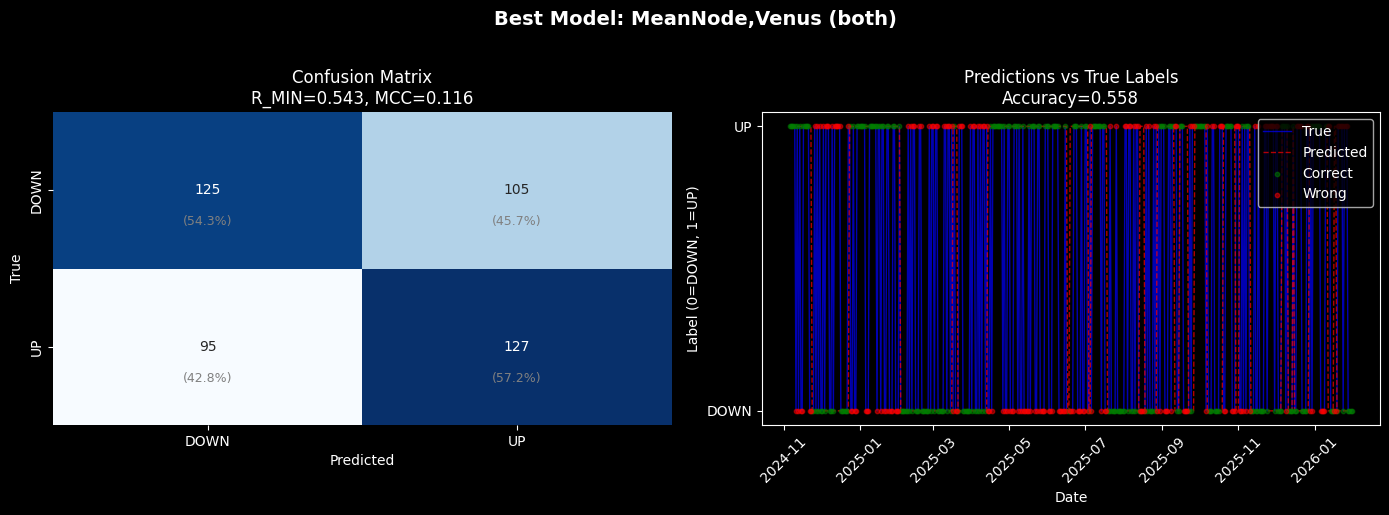

OSError: Cannot save file into a non-existent directory: 'RESEARCH/reports'

In [11]:
# =============================================================================
# SCRIPT ENTRY POINT
# =============================================================================

if __name__ == "__main__":
    results_df, best_result = main()